In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import time
from scripts import *
import scipy.linalg as la

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split as tts, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

from plotMatriz import plotMatriz
from sklearn.decomposition import TruncatedSVD

In [2]:
stemmed_data_path = 'Dados/stemsnowball.p'
dados_path = 'Dados/imdbFull.p'
final_tfidf_bin = 'tfidf/tfidf_binario.p'

In [3]:
D = pickle.load(open(stemmed_data_path, 'rb'))
D.keys()

dict_keys(['Docs', 'y'])

In [4]:
Docs = D['Docs']
y = D['y']

yB = y.copy()

yB[yB < 5] = 0
yB[yB > 6] = 1

In [5]:
Docs1_b, Docs2_b, y1_b, y2_b     = tts(Docs, yB, test_size=1/4, stratify=yB,random_state=42)
Docs1t_b, Docs1v_b, y1t_b, y1v_b = tts(Docs1_b, y1_b, test_size=1/3, stratify=y1_b,random_state=42) 

In [6]:
tfidf_b = pickle.load(open(final_tfidf_bin, 'rb'))['tfidf']
X1t_b, X1v_b = tfidf_b.transform(Docs1t_b), tfidf_b.transform(Docs1v_b)

In [7]:
componentes = np.arange(500,3501,500)

resultados_b = []

for comps in componentes:
    print('Número de componentes', comps)
    svd = TruncatedSVD(n_components=comps, n_iter=5).fit(X1t_b)
    X1t_SVD_b = svd.transform(X1t_b)
    X1v_SVD_b = svd.transform(X1v_b)
    logReg = LogisticRegression( penalty='l2', solver='liblinear', C=4.5, max_iter=5000, tol=1e-2,random_state=42)
    logReg.fit(X1t_SVD_b,y1t_b)

    resultados_b.append( (logReg.score(X1t_SVD_b, y1t_b)*100,logReg.score(X1v_SVD_b, y1v_b)*100) ) #(treino,validação)
    


Número de componentes 500
Número de componentes 1000
Número de componentes 1500
Número de componentes 2000
Número de componentes 2500
Número de componentes 3000
Número de componentes 3500


In [8]:
svd_bin = 'Resultados/svd_bin.p'

In [9]:
dict_results_bin = {'results' : resultados_b }

pickle.dump(dict_results_bin, open(svd_bin, 'wb'))

In [10]:
def annot_max(x,y,ax=None):
    xmax = x[np.argmax(y)]
    ymax = np.max(y)

    text= "número de componentes" + str(xmax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.56), **kw)

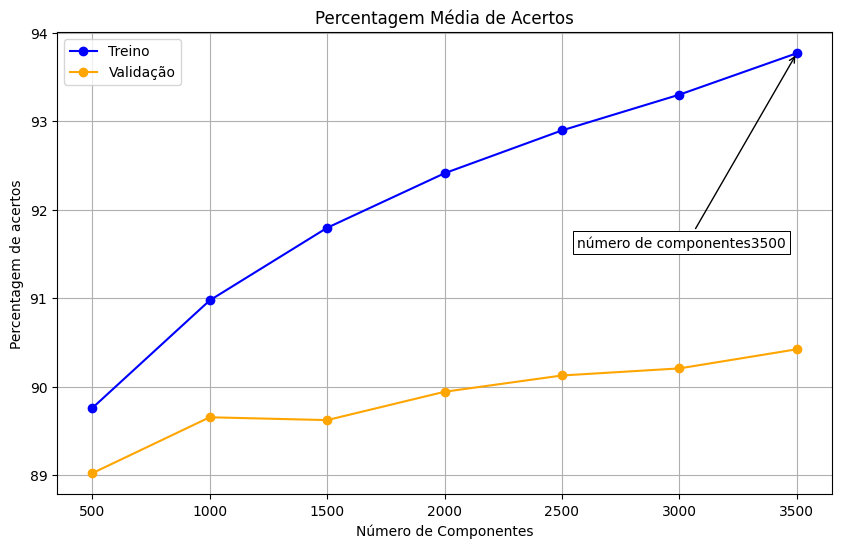

In [11]:
resultados_pca = pickle.load(open(svd_bin, 'rb'))['results']

t = [i[0] for i in resultados_pca]
v = [i[1] for i in resultados_pca]

plt.figure(figsize=(10,6))
plt.plot(np.arange(500, 3501, 500), t, '-o', color='blue')
annot_max(np.arange(500, 3501, 500), t)
plt.plot(np.arange(500, 3501, 500), v, '-o', color='orange')
plt.title('Percentagem Média de Acertos')
plt.xlabel('Número de Componentes')
plt.ylabel('Percentagem de acertos')
plt.legend(('Treino', 'Validação'))
plt.grid() 
plt.show()

In [12]:
Docs1_b, Docs2_b, y1_b, y2_b     = tts(Docs, yB, test_size=1/4, stratify=yB, random_state=42)
Docs1t_b, Docs1v_b, y1t_b, y1v_b = tts(Docs1_b, y1_b, test_size=1/3, stratify=y1_b, random_state=42) 

#melhores parametros no binario
best_pars_b = [(5),              #min_df
             (r'\b\w\w+\b'),   #token
             ((1,2)),          #ngram
             ('l2'),           #penalty
             (4.5)]            #C   
              
# Vetorização
tfidf_bin  = TfidfVectorizer(min_df = best_pars_b[0], token_pattern=best_pars_b[1], ngram_range=best_pars_b[2]).fit(Docs1t_b)

X1t_b = tfidf_bin.transform(Docs1t_b)
X1v_b = tfidf_bin.transform(Docs1v_b)
X2_b  = tfidf_bin.transform(Docs2_b)

#PCA truncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=5)
svd.fit(X1t_b)
X1t_SVD_b = svd.transform(X1t_b)
X1v_SVD_b = svd.transform(X1v_b)
X2_SVD_b  = svd.transform(X2_b)


# Regressão Logística
lr_bin = LogisticRegression(penalty=best_pars_b[3], solver='liblinear', C=best_pars_b[4], max_iter=5000, tol=1e-2,random_state=42)
lr_bin.fit(X1t_b, y1t_b)

lr_PCA_bin = LogisticRegression(penalty=best_pars_b[3], solver='liblinear', C = best_pars_b[4], max_iter=5000, tol=1e-2,random_state=42)
lr_PCA_bin.fit(X1t_SVD_b, y1t_b)


LogisticRegression(C=4.5, max_iter=5000, random_state=42, solver='liblinear',
                   tol=0.01)

In [13]:
# Resultados
print('Avaliação final Sem PCA:')
print('Score Treino:    ', lr_bin.score(X1t_b, y1t_b)*100)
print('Score Validação: ', lr_bin.score(X1v_b, y1v_b)*100)
print('Score Teste:     ', lr_bin.score(X2_b, y2_b)*100,'\n')

# Resultados
print('Avaliação final com PCA:')
print('Score Treino:    ', lr_PCA_bin.score(X1t_SVD_b, y1t_b)*100)
print('Score Validação: ', lr_PCA_bin.score(X1v_SVD_b, y1v_b)*100)
print('Score Teste:     ', lr_PCA_bin.score(X2_SVD_b, y2_b)*100)

Avaliação final Sem PCA:
Score Treino:     98.86399999999999
Score Validação:  90.8
Score Teste:      90.928 

Avaliação final com PCA:
Score Treino:     89.89200000000001
Score Validação:  89.048
Score Teste:      89.024


#### Multiclasse

In [14]:
final_tfidf_multi = 'tfidf/tfidf_multiclasse.p'

In [15]:
D = pickle.load(open(stemmed_data_path, 'rb'))
D.keys()

dict_keys(['Docs', 'y'])

In [16]:
Docs = D['Docs']
y = D['y']

In [17]:
Docs1_m, Docs2_m, y1_m, y2_m     = tts(Docs, y, test_size=1/4, stratify=y,random_state=42)
Docs1t_m, Docs1v_m, y1t_m, y1v_m = tts(Docs1_m, y1_m, test_size=1/3, stratify=y1_m,random_state=42) 

In [18]:
tfidf_m = pickle.load(open(final_tfidf_multi, 'rb'))['tfidf']
X1t_m, X1v_m = tfidf_m.transform(Docs1t_m), tfidf_m.transform(Docs1v_m)

In [19]:
componentes = np.arange(500,3501,500)

resultados_m = []

for comps in componentes:
    print('Número de componentes', comps)
    svd = TruncatedSVD(n_components=comps, n_iter=5).fit(X1t_m)
    X1t_SVD_m = svd.transform(X1t_m)
    X1v_SVD_m = svd.transform(X1v_m)
    logReg = LogisticRegression( penalty='l2', solver='saga', C=1.5, max_iter=5000, tol=1e-2,random_state=42)
    logReg.fit(X1t_SVD_m,y1t_m)

    resultados_m.append( (logReg.score(X1t_SVD_m, y1t_m)*100,logReg.score(X1v_SVD_m, y1v_m)*100) ) #(treino,validação)
    


Número de componentes 500
Número de componentes 1000
Número de componentes 1500
Número de componentes 2000
Número de componentes 2500
Número de componentes 3000
Número de componentes 3500


In [20]:
svd_multi = 'Resultados/svd_multi.p'

In [21]:
dict_results_multi = {'results' : resultados_m }

pickle.dump(dict_results_multi, open(svd_multi, 'wb'))

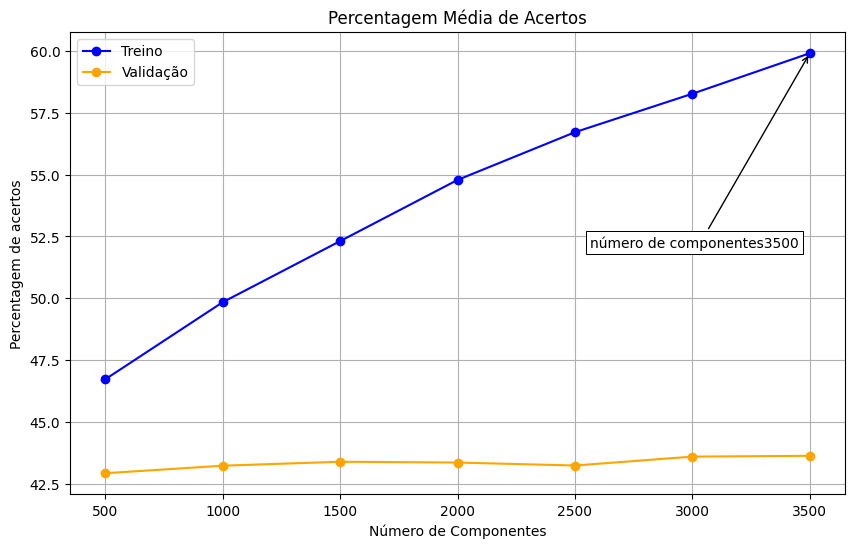

In [22]:
resultados_pca = pickle.load(open(svd_multi, 'rb'))['results']

t = [i[0] for i in resultados_pca]
v = [i[1] for i in resultados_pca]

plt.figure(figsize=(10,6))
plt.plot(np.arange(500, 3501, 500), t, '-o', color='blue')
annot_max(np.arange(500, 3501, 500), t)
plt.plot(np.arange(500, 3501, 500), v, '-o', color='orange')
plt.title('Percentagem Média de Acertos')
plt.xlabel('Número de Componentes')
plt.ylabel('Percentagem de acertos')
plt.legend(('Treino', 'Validação'))
plt.grid() 
plt.show()

In [23]:
Docs1_m, Docs2_m, y1_m, y2_m     = tts(Docs, y, test_size=1/4, stratify=y,random_state=42)
Docs1t_m, Docs1v_m, y1t_m, y1v_m = tts(Docs1_m, y1_m, test_size=1/3, stratify=y1_m,random_state=42) 


best_pars_m = [(5),              #min_df
             (r'\b\w\w\w+\b'),   #token
             ((1,2)),          #ngram
             ('l2'),           #penalty
             (1.5)]            #C    
              
# Vetorização
tfidf_multi  = TfidfVectorizer(min_df = best_pars_m[0], token_pattern=best_pars_m[1], ngram_range=best_pars_m[2]).fit(Docs1t_b)

X1t_m = tfidf_multi.transform(Docs1t_m)
X1v_m = tfidf_multi.transform(Docs1v_m)
X2_m  = tfidf_multi.transform(Docs2_m)

#PCA truncatedSVD
svd = TruncatedSVD(n_components=500, n_iter=5)
svd.fit(X1t_m)
X1t_SVD_m = svd.transform(X1t_m)
X1v_SVD_m = svd.transform(X1v_m)
X2_SVD_m  = svd.transform(X2_m)


# Regressão Logística
lr_multi = LogisticRegression(penalty=best_pars_m[3], solver='saga', C=best_pars_m[4], max_iter=5000, tol=1e-2,random_state=42)
lr_multi.fit(X1t_m, y1t_m)

lr_PCA_multi = LogisticRegression(penalty=best_pars_m[3], solver='saga', C = best_pars_m[4], max_iter=5000, tol=1e-2,random_state=42)
lr_PCA_multi.fit(X1t_SVD_m, y1t_m)


LogisticRegression(C=1.5, max_iter=5000, random_state=42, solver='saga',
                   tol=0.01)

In [24]:
# Resultados
print('Avaliação final Sem PCA:')
print('Score Treino:    ', lr_multi.score(X1t_m, y1t_m)*100)
print('Score Validação: ', lr_multi.score(X1v_m, y1v_m)*100)
print('Score Teste:     ', lr_multi.score(X2_m, y2_m)*100,'\n')

# Resultados
print('Avaliação final com PCA:')
print('Score Treino:    ', lr_PCA_multi.score(X1t_SVD_m, y1t_m)*100)
print('Score Validação: ', lr_PCA_multi.score(X1v_SVD_m, y1v_m)*100)
print('Score Teste:     ', lr_PCA_multi.score(X2_SVD_m, y2_m)*100)

Avaliação final Sem PCA:
Score Treino:     87.29599999999999
Score Validação:  43.552
Score Teste:      43.616 

Avaliação final com PCA:
Score Treino:     47.128
Score Validação:  43.344
Score Teste:      42.92
